In [ ]:
from keras.api.applications import EfficientNetB0
from keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras
import tensorflow
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
# B0 - 224x224
# B3 - 300x300
RESOLUTION = 224

realwaste = keras.utils.image_dataset_from_directory(
    "./data/realwaste",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=BATCH_SIZE
)

trashnet = keras.utils.image_dataset_from_directory(
    "./data/trashnet",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=BATCH_SIZE
)

Found 3587 files belonging to 6 classes.
Found 2527 files belonging to 6 classes.


In [28]:
def split(ds, train_split=0.8, val_split=0.1):
    ds_size = len(list(ds.as_numpy_iterator()))
    ds = ds.shuffle(3600, reshuffle_each_iteration=False)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

training_dataset, validation_dataset, test_dataset = split(realwaste)

In [ ]:
augmentation_layers = [
    # Lighting variations
    layers.RandomBrightness(factor=(-0.3, 0.3)),
    # Blurring
    layers.GaussianNoise(stddev=0.2),
    # Distortions
    layers.RandomRotation(factor=0.2, fill_mode='nearest'),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    # Color variations
    layers.RandomContrast(factor=(0.7, 1.3)),
]

def augment(image):
    for layer in augmentation_layers:
        image = layer(image)
    return image

In [32]:
NUM_CLASSES = 6

def preprocess_augment(image, label):
    image = tensorflow.image.resize(image, (RESOLUTION, RESOLUTION))
    image = augment(image)
    return image, label

def resize(image, label):
    image = tensorflow.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, label

# Preprocess training
training_dataset = training_dataset.map(preprocess_augment, num_parallel_calls=tensorflow.data.AUTOTUNE)
training_dataset = training_dataset.prefetch(tensorflow.data.AUTOTUNE)

# Preprocess validation & test
validation_dataset = validation_dataset.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)

test_dataset = test_dataset.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)
trash_test_dataset = trashnet.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)

In [33]:
inputs = layers.Input(shape=(RESOLUTION, RESOLUTION, 3))
model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze layers so we can train the top layers
model.trainable = False

# Recreate top layers
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile model
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 594ms/step - accuracy: 0.3972 - loss: 2.4879 - val_accuracy: 0.5426 - val_loss: 1.3070
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 564ms/step - accuracy: 0.5250 - loss: 2.2857 - val_accuracy: 0.6449 - val_loss: 1.1221
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 560ms/step - accuracy: 0.5355 - loss: 2.2248 - val_accuracy: 0.6506 - val_loss: 1.1892
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 560ms/step - accuracy: 0.5418 - loss: 2.1444 - val_accuracy: 0.7216 - val_loss: 0.9728
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 563ms/step - accuracy: 0.5364 - loss: 1.9382 - val_accuracy: 0.6989 - val_loss: 0.8717
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 564ms/step - accuracy: 0.5597 - loss: 1.6407 - val_accuracy: 0.6562 - val_loss: 1.2167
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 573ms/step - accuracy: 0.5709 - loss: 1.5979 - val_accuracy: 0.6761 - val_loss: 1.0438
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 557ms/step - accuracy: 0.5497 - loss: 1.4457 - val_accu

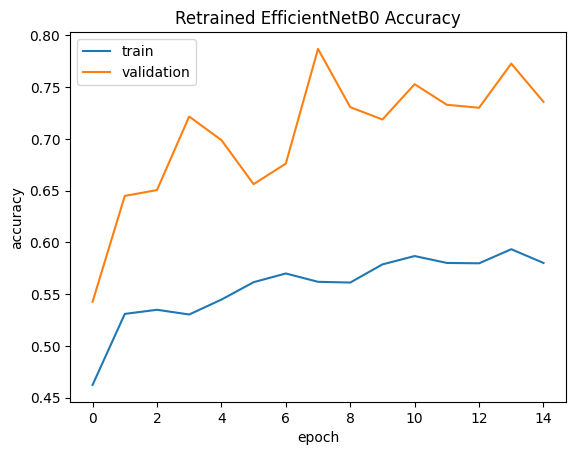

In [ ]:
epochs = 15
trained = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset)

def plot_results(data):
    plt.plot(data.history["accuracy"])
    plt.plot(data.history["val_accuracy"])
    plt.title("Retrained EfficientNetB0 Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_results(trained)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 656ms/step - accuracy: 0.6819 - loss: 0.8695 - val_accuracy: 0.8466 - val_loss: 0.4444
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 633ms/step - accuracy: 0.7011 - loss: 0.8034 - val_accuracy: 0.8011 - val_loss: 0.5455
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 628ms/step - accuracy: 0.7183 - loss: 0.7381 - val_accuracy: 0.8011 - val_loss: 0.4942
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 631ms/step - accuracy: 0.7241 - loss: 0.7341 - val_accuracy: 0.8210 - val_loss: 0.4926
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 637ms/step - accuracy: 0.7353 - loss: 0.7306 - val_accuracy: 0.8111 - val_loss: 0.4724


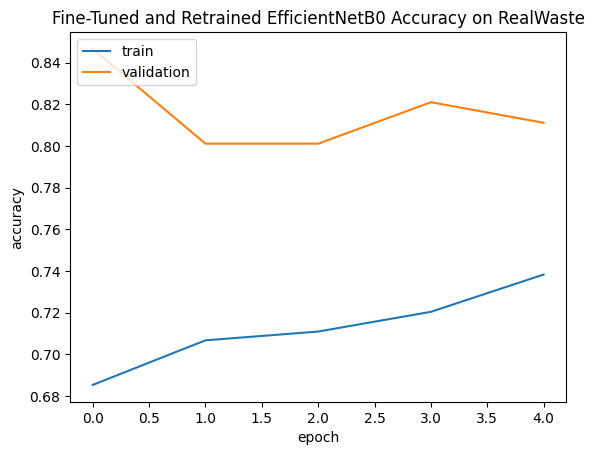

In [39]:
for layer in model.layers[-40:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 5
unfrozen_train = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, shuffle=True)

def plot_tuned(data):
    plt.plot(data.history["accuracy"])
    plt.plot(data.history["val_accuracy"])
    plt.title("Fine-Tuned and Retrained EfficientNetB0 Accuracy on RealWaste")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_tuned(unfrozen_train)

In [40]:
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print("Test on unseen RealWaste")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - accuracy: 0.7873 - loss: 0.5692
Test on unseen RealWaste
Test Accuracy: 0.8047
Test Loss: 0.5342


In [1]:
# Evaluate on TrashNet
predictions = model.predict(trash_test_dataset)
print("Test on TrashNet")
print(f"Test Accuracy: {predictions:.4f}")

NameError: name 'model' is not defined